# 3.0 Pipeline

In [110]:
import numpy as np
import pandas as pd

import pathlib
import joblib
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score\
                            , recall_score, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

In [50]:
PROJECT_DIR = pathlib.Path().resolve().parent

DATA_DIR = PROJECT_DIR / "data/data_src"
SRC_DATA = DATA_DIR / "data.csv"

#### Load data make X and y

In [51]:
source_data = pd.read_csv(SRC_DATA)
label_data = source_data[['default.payment.next.month']]
features_data = source_data.loc[:,source_data.columns != 'default.payment.next.month']
print(label_data.shape)
print(features_data.shape)

(10000, 1)
(10000, 25)


#### Split data in train and test

In [87]:
(X_train, X_test, y_train, y_test) = train_test_split(features_data, label_data,
                                                      test_size=0.2,
                                                      random_state=42, stratify=label_data)
print(X_train.shape)

(8000, 25)
      default.payment.next.month
6783                           1
3402                           0
3459                           0
5764                           1
6492                           0


In [53]:
#Upsample
# Separate majority and minority classes
index_majority = y_train[y_train['default.payment.next.month'] == 0].index.values
index_minority = y_train[y_train['default.payment.next.month'] == 1].index.values

df_majority = X_train.loc[index_majority,:]
df_minority = X_train.loc[index_minority,:]

print('df_majority.shape', df_majority.shape, 'df_minority.shape', df_minority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority 
                                 , replace      = True     # sample with replacement
                                 , n_samples    = df_majority.shape[0]    # to match majority class
                                 , random_state = 42) # reproducible results

print('df_majority.shape:', df_majority.shape, 'df_minority_upsampled.shape:', df_minority_upsampled.shape)

# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
y_train_upsampled = y_train.loc[X_train_upsampled.index,:]

X_train_upsampled = X_train_upsampled.reset_index(drop=True)
y_train_upsampled = y_train_upsampled.reset_index(drop=True)
 
# Display new class counts
print('X_train_upsampled.shape:', X_train_upsampled.shape)
print('y_train_upsampled.shape:', y_train_upsampled.shape)

df_majority.shape (6210, 25) df_minority.shape (1790, 25)
df_majority.shape: (6210, 25) df_minority_upsampled.shape: (6210, 25)
X_train_upsampled.shape: (12420, 25)
Y_train_upsampled.shape: (12420, 1)


In [54]:
# Use dict to translate
GENDER_dict = {1:'male', 2:'female'}
GENDER_inv = {v:k for k,v in GENDER_dict.items()}
EDUCATION_dict = {0: 'education_other', 1 : 'graduate_school', 2 : 'university', 3: 'high_school'\
                  , 4 : 'education_other', 5 : 'education_other', 6 : 'education_other'}
EDUCATION_inv = {v:k for k,v in EDUCATION_dict.items()}
MARRIAGE_dict = {0:'marriage_other', 1:'married', 2:'single', 3:'marriage_other'}
MARRIAGE_inv = {v:k for k,v in MARRIAGE_dict.items()}
label_dict = {0: 'yes', 1:'no'}
label_inv = {v:k for k,v in label_dict.items()}

In [88]:
X_train = X_train_upsampled

# Pre pipeline process
# Remove cols ID and Pay_0 to Pay_7 for now
cols_to_drop = ['PAY_' + str(i) for i in range(7)] + ['ID']
X_train = X_train.drop(columns=cols_to_drop)
# Combine categories in categorical data
X_train['EDUCATION'] = X_train['EDUCATION'].replace(EDUCATION_dict)
X_train['MARRIAGE'] = X_train['MARRIAGE'].replace(MARRIAGE_dict)
X_train['SEX'] = X_train['SEX'].replace(MARRIAGE_dict)
# Use BAL_AMT = BILL_AMT - PAY_AMT
BAL_cols = ['BAL_AMT'+str(i+1) for i in range(6)]
BILL_cols = ['BILL_AMT'+str(i+1) for i in range(6)]
PAY_cols = ['PAY_AMT'+str(i+1) for i in range(6)]

for i,j,k in zip(BAL_cols, BILL_cols,PAY_cols):
    X_train[i] = X_train[j] - X_train[k]
    X_train = X_train.drop(columns=[j,k])

In [89]:
print(X_train.head())

   LIMIT_BAL      SEX        EDUCATION MARRIAGE  AGE  BAL_AMT1  BAL_AMT2  \
0    50000.0  married       university   single   45   28359.0   26717.0   
1   200000.0   single  graduate_school  married   59   87915.0   89585.0   
2    90000.0  married       university   single   32   70114.0   69032.0   
3   100000.0   single       university   single   26   50743.0   49820.0   
4   500000.0   single  graduate_school   single   38   70605.0   67679.0   

   BAL_AMT3  BAL_AMT4  BAL_AMT5  BAL_AMT6  
0   14177.0   14949.0   11319.0   15119.0  
1   91736.0   94216.0   95690.0   97912.0  
2   63954.0   50952.0   45077.0   34547.0  
3   43686.0   42497.0   39674.0   40053.0  
4   63761.0   65260.0   66143.0   63506.0  


In [90]:
# Get col types
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(include=["number"]).columns
feature_arr = num_cols.to_list() + cat_cols.to_list() 
label_cols = ['default.payment.next.month']
print(feature_arr)

['LIMIT_BAL', 'AGE', 'BAL_AMT1', 'BAL_AMT2', 'BAL_AMT3', 'BAL_AMT4', 'BAL_AMT5', 'BAL_AMT6', 'SEX', 'EDUCATION', 'MARRIAGE']


In [91]:
# Apply preprocess
preprocessor = ColumnTransformer(
    transformers=[('nums', RobustScaler(), num_cols), 
                    ('cats', OneHotEncoder(sparse=False), cat_cols)
                    ])

# ('pass','passthrough', num_cols)

#Transform data
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_pipe = pipe.fit_transform(X_train)

# Save pipe
fname_pipe = PROJECT_DIR / "artifacts/pipe.joblib"
joblib.dump(pipe, fname_pipe)


['C:\\Users\\PatCa\\Documents\\PythonScripts\\Project1\\artifacts\\pipe.joblib']

In [82]:
#Make list of feature names after one-hot
feature_list = []
for name, estimator, features in preprocessor.transformers_:
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator,OneHotEncoder):
            f = estimator.get_feature_names_out(features)
            feature_list.extend(f)
    else:
        feature_list.extend(features)
        
print(feature_list)

['LIMIT_BAL', 'AGE', 'BAL_AMT1', 'BAL_AMT2', 'BAL_AMT3', 'BAL_AMT4', 'BAL_AMT5', 'BAL_AMT6', 'SEX_married', 'SEX_single', 'EDUCATION_education_other', 'EDUCATION_graduate_school', 'EDUCATION_high_school', 'EDUCATION_university', 'MARRIAGE_marriage_other', 'MARRIAGE_married', 'MARRIAGE_single']


In [92]:
# Pre pipeline process
# Remove cols ID and Pay_0 to Pay_7 for now
cols_to_drop = ['PAY_' + str(i) for i in range(7)] + ['ID']
X_test = X_test.drop(columns=cols_to_drop)
# Combine categories in categorical data
X_test['EDUCATION'] = X_test['EDUCATION'].replace(EDUCATION_dict)
X_test['MARRIAGE'] = X_test['MARRIAGE'].replace(MARRIAGE_dict)
X_test['SEX'] = X_test['SEX'].replace(MARRIAGE_dict)
# Use BAL_AMT = BILL_AMT - PAY_AMT
BAL_cols = ['BAL_AMT'+str(i+1) for i in range(6)]
BILL_cols = ['BILL_AMT'+str(i+1) for i in range(6)]
PAY_cols = ['PAY_AMT'+str(i+1) for i in range(6)]

for i,j,k in zip(BAL_cols, BILL_cols,PAY_cols):
    X_test[i] = X_test[j] - X_test[k]
    X_test = X_test.drop(columns=[j,k])


X_test_pipe = pipe.transform(X_test)
print(X_train_pipe.shape)
print(X_test_pipe.shape)

(12420, 17)
(2000, 17)


In [93]:
pd.DataFrame(X_train_pipe, columns=feature_list).to_csv(PROJECT_DIR / "data/data_artifacts/X_train_pipe.csv", index=False)
pd.DataFrame(X_test_pipe, columns=feature_list).to_csv(PROJECT_DIR / "data/data_artifacts/X_ttest_pipe.csv", index=False)
pd.DataFrame(y_train_upsampled).to_csv(PROJECT_DIR / "data/data_artifacts/y_train.csv", index=False)
pd.DataFrame(y_test).to_csv(PROJECT_DIR / "data/data_artifacts/y_test.csv", index=False)

In [84]:
a = pd.read_csv(PROJECT_DIR / "data/data_artifacts/X_train_pipe.csv")
print(a.shape)
a.head()

(8000, 17)


,LIMIT_BAL,AGE,BAL_AMT1,BAL_AMT2,BAL_AMT3,BAL_AMT4,BAL_AMT5,BAL_AMT6,SEX_married,SEX_single,EDUCATION_education_other,EDUCATION_graduate_school,EDUCATION_high_school,EDUCATION_university,MARRIAGE_marriage_other,MARRIAGE_married,MARRIAGE_single
0,1.105263,0.769231,-0.273363,-0.307968,-0.257484,-0.344189,-0.316025,-0.302309,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.473684,0.846154,0.171962,0.150001,-0.060446,-0.034980,-0.079362,0.053784,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.315789,1.923077,1.148678,1.216713,1.318423,1.569184,1.737687,1.893077,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.473684,0.923077,0.501371,0.418868,0.505136,0.055744,0.086016,0.088462,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.263158,-0.153846,0.856742,0.867980,0.824506,0.693630,0.647664,0.485388,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### 4.0 Baseline Model
#### Make XGBoost baseline model   

In [96]:
eval_metric = ['logloss','auc']
eval_set = [(X_train_pipe, y_train_upsampled),(X_test_pipe, y_test)]

clf = XGBClassifier(use_label_encoder=False)
xgb_baseline = clf.fit(X_train_pipe, y_train_upsampled,
                       eval_set=eval_set, eval_metric=eval_metric,
                       #early_stopping_rounds=10, 
                       verbose=True)

[0]	validation_0-logloss:0.65582	validation_0-auc:0.71052	validation_1-logloss:0.67225	validation_1-auc:0.61803
[1]	validation_0-logloss:0.63424	validation_0-auc:0.73139	validation_1-logloss:0.66076	validation_1-auc:0.63762
[2]	validation_0-logloss:0.61713	validation_0-auc:0.74690	validation_1-logloss:0.65542	validation_1-auc:0.63751
[3]	validation_0-logloss:0.60261	validation_0-auc:0.75957	validation_1-logloss:0.64866	validation_1-auc:0.64652
[4]	validation_0-logloss:0.59400	validation_0-auc:0.76481	validation_1-logloss:0.64591	validation_1-auc:0.64746
[5]	validation_0-logloss:0.58771	validation_0-auc:0.77001	validation_1-logloss:0.64406	validation_1-auc:0.64664
[6]	validation_0-logloss:0.58212	validation_0-auc:0.77461	validation_1-logloss:0.64232	validation_1-auc:0.64615
[7]	validation_0-logloss:0.57167	validation_0-auc:0.78466	validation_1-logloss:0.64096	validation_1-auc:0.64381
[8]	validation_0-logloss:0.56647	validation_0-auc:0.79058	validation_1-logloss:0.63874	validation_1-auc:

In [100]:
# Save Model
BASELINE = PROJECT_DIR / "artifacts/xgb_baseline"
pickle.dump(xgb_baseline, open(BASELINE, "wb"))

#Load 
trained_xgb_baseline = pickle.load(open(BASELINE, "rb"))

### 4.x Checking training

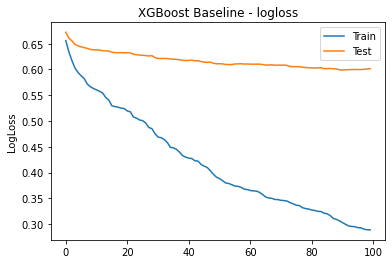

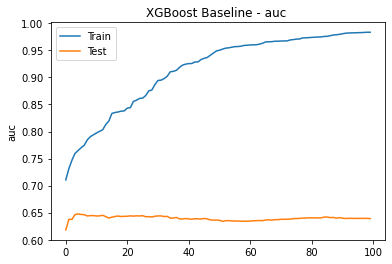

In [104]:
results = trained_xgb_baseline.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('LogLoss')
plt.title('XGBoost Baseline - logloss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost Baseline - auc ')
plt.show()

### 4.x Baseline metrics

In [111]:
def try_func(func, y_data, predictions):
    try:
        return func(y_data,predictions).round(2)
    except Exception as E:
        print(E)
        return np.nan

def calc_metrics(classifier, x_data, y_data):

    shape_x, shape_y = (x_data.shape, y_data.shape)
    print('Data shapes X:', shape_x, 'Y:', shape_y)
    predictions = classifier.predict(x_data) 

    
    acc  = try_func(accuracy_score, y_data, predictions)
    f1   = try_func(f1_score, y_data, predictions)
    prec = try_func(precision_score, y_data, predictions)
    rec  = try_func(recall_score, y_data, predictions)
    roc  = try_func(roc_auc_score, y_data, predictions)
    

    print('Metrics model -', 'accuracy:', acc, 'f1:', f1, 'precision:', prec, 'recall:', rec, 'roc_auc:', roc) 
    return [acc, f1, prec, rec, roc, shape_x, shape_y]

In [112]:
print("Metrics XGB classifier baseline on test data")
results_baseline_test = calc_metrics(trained_xgb_baseline, X_test_pipe, y_test.values)

Metrics XGB classifier baseline on test data
Data shapes X: (2000, 17) Y: (2000, 1)
Metrics model - accuracy: 0.69 f1: 0.37 precision: 0.34 recall: 0.42 roc_auc: 0.59
